In [1]:
import keras

Using TensorFlow backend.


In [ ]:
# We now consider class activation map (CAM) visualization, 
# which consists of producing heatmaps of class activation over input images
#
# A class activation heatmap is a 2D grid of scores associated with a specific output class, 
# computed for every location in any input image, indicating how important each location is with
# respect to the class under consideration.
#
# Specifically, we will take the output feature map of a convolutional layer, given an input image
# and weight every channel in that feature map by the gradient of the class with respect to the channel.

In [1]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Using TensorFlow backend.


553467904/553467096 [==============================] - 7s 0us/step


In [2]:
# We now use an image, converting it to 224 × 224 and then to a numpy float32 tensor
# and applying some pre-processing rules.

In [5]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [9]:
img_path = "/home/ec2-user/datasets/elephant/african-elephant-mother-leading-calf-tim-fitzharris.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [12]:
# Now let's apply the model to predict the class of this image.
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n01871265', 'tusker', 0.54465467), ('n02504458', 'African_elephant', 0.26927155), ('n02504013', 'Indian_elephant', 0.18384209)]


In [14]:
# Finding the class with the highest probability
np.argmax(preds[0])

101

In [21]:
# The maximum class activation is for Tusker. We can now visualise the parts of the image that
# activate the network the most.
from keras import backend as K
output = model.output[:, 101]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

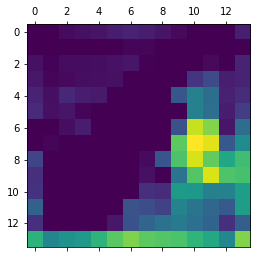

In [25]:
# Then for visualisation purposes we normalise the heatmap between 0 and 1
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [28]:
# We can see the parts of the image that most activate the convnet. Now we can also super-impose
# the heatmap on the original image and fully understand what parts of it lead to the classification
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/home/ec2-user/datasets/elephant/elephant_cam.jpg', superimposed_img)

True

In [32]:
from keras.preprocessing import image 
import numpy as np
img_tensor = image.img_to_array(superimposed_img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

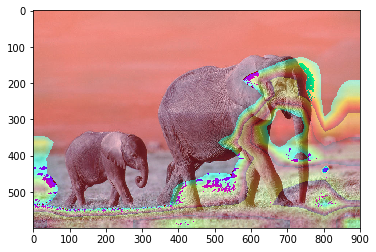

In [34]:
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# We can see that the model focuses on the head of one of the elephants... This explains the output.